In [1]:
import os
import numpy as np
import logging
from train_test import train, evaluate
import warnings
import json
import wandb
from arg_parser import init_parser
from setproctitle import setproctitle as ptitle
from enviroment import ARC_Env
import gymnasium as gym
from action_space import ARCActionSpace
import torch

In [2]:
import argparse

def init_parser(alg):
    """Initialize argument parser for the specified algorithm."""

    if alg == 'WOLP_DDPG':
        parser = argparse.ArgumentParser(description='WOLP_DDPG')

        # Environment & Training Mode
        parser.add_argument('--env', default='ARC', metavar='ENV', help='Environment to train on')
        parser.add_argument('--mode', default='train', type=str, help='Mode: train/test')
        parser.add_argument('--id', default='0', type=str, help='Experiment ID')
        parser.add_argument('--load', default=False, metavar='L', help='Load a trained model')
        parser.add_argument('--load-model-dir', default='ARC-run780', metavar='LMD', help='Folder to load trained models from')
        parser.add_argument('--eval-interval', default=200, type=int, help='Evaluate model every X episodes')
        parser.add_argument('--eval-episodes', default=2, type=int, help='Number of episodes to evaluate')

        # Episode & Training Settings
        parser.add_argument('--max-episode-length', type=int, default=50, metavar='M', help='Max episode length (default: 50)')  # Changed from 1440
        parser.add_argument('--max-episode', type=int, default=20000, help='Maximum number of episodes')
        parser.add_argument('--max-actions', default=12, type=int, help='# max actions')
        parser.add_argument('--test-episode', type=int, default=20, help='Maximum testing episodes')
        parser.add_argument('--warmup', default=200, type=int, help='Time without training but only filling the replay memory')
        parser.add_argument('--bsize', default=3, type=int, help='Minibatch size')
        parser.add_argument('--rmsize', default=100000, type=int, help='Replay memory size')

        # Policy Update Settings
        parser.add_argument('--gamma', type=float, default=0.99, metavar='G', help='Discount factor for rewards (default: 0.99)')
        parser.add_argument('--policy-noise', default=0, type=float, help='Noise added to target policy during critic update')
        parser.add_argument('--noise-clip', default=0.25, type=float, help='Range to clip target policy noise')
        parser.add_argument('--policy-delay', default=2, type=int, help='Delay policy updates')
        parser.add_argument('--c-lr', default=3e-4, type=float, help='Critic network learning rate')
        parser.add_argument('--p-lr', default=3e-4, type=float, help='Policy network learning rate (for DDPG)')
        parser.add_argument('--tau-update', default=0.0005, type=float, help='Moving average for target network')
        parser.add_argument('--weight-decay', default=1e-4, type=float, help='L2 Regularization loss weight decay')
        
                            
        # Neural Network Architecture
        parser.add_argument('--hidden1', default=1024, type=int, help='Hidden units in the first fully connected layer')
        parser.add_argument('--hidden2', default=1024, type=int, help='Hidden units in the second fully connected layer')
        parser.add_argument('--actor_critic_type', default='cnn', type=str, help='Type of model (lpn, cnn, mlp)')
        parser.add_argument('--latent_dim', default=48, type=int, help='Latent dimension for encoder')

        # Exploration & Noise
        parser.add_argument('--epsilon', default=100000, type=int, help='Linear decay of exploration policy')
        parser.add_argument('--epsilon_start', default=1.0, type=float, help='Starting epsilon value for resuming training')
        parser.add_argument('--ou_theta', default=0.5, type=float, help='Ornstein-Uhlenbeck noise theta')
        parser.add_argument('--ou_sigma', default=0.2, type=float, help='Ornstein-Uhlenbeck noise sigma')
        parser.add_argument('--ou_mu', default=0.0, type=float, help='Ornstein-Uhlenbeck noise mu')

        # Hardware & GPU Settings
        parser.add_argument('--gpu-ids', type=int, default=[1], nargs='+', help='GPUs to use [-1 for CPU only]')
        parser.add_argument('--gpu-nums', type=int, default=8, help='Number of GPUs to use (default: 1)')

        # Action Embedding & Filtering
        parser.add_argument('--load_action_embedding', default=True, type=bool, help='Load action embedding or not')
        parser.add_argument('--num_experiments_filter', default=120, type=int, help='Number of problems used for filtering actions')
        parser.add_argument('--filter_threshold', default=0.3, type=float, help='Threshold percentage for filtering actions')
        parser.add_argument('--num_experiments_similarity', default=120, type=int, help='Number of problems used for similarity matrix calculation')
        parser.add_argument('--max_embedding', default=1., type=float, help='Maximum value for embedding matrix')
        parser.add_argument('--min_embedding', default=-1., type=float, help='Minimum value for embedding matrix')

        # Miscellaneous
        parser.add_argument('--init_w', default=0.003, type=float, help='Initial weight')
        parser.add_argument('--seed', default=-1, type=int, help='Random seed')
        parser.add_argument('--save_per_epochs', default=25, type=int, help='Save model every X epochs')
        parser.add_argument('--k_neighbors', default=25, type=int, help='Number of neighbors to consider')
        return parser

    else:
        raise RuntimeError(f'Undefined algorithm {alg}')

In [3]:
import sys
sys.argv = ['notebook']  # Replace with a dummy argument list

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print('Using device: {}'.format(device))


ptitle('WOLP_DDPG')
warnings.filterwarnings('ignore')
parser = init_parser('WOLP_DDPG')
args = parser.parse_args()

os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_ids)[1:-1]

Using device: mps


wandb: WARNING Unable to verify login in offline mode.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Using device for model: mps
Using device for EncoderTransformer: mps
Using device for memory: mps
Using device: mps


--------------------------------------------------
Creating the action space
Number of actions not filtered: 11310
Number of actions filtered: 7075
NearestNeighbors model created with 25 neighbors
--------------------------------------------------
--------------------------------------------------
Creating the action space
Number of actions not filtered: 11310
Number of actions filtered: 7075
NearestNeighbors model created with 25 neighbors
--------------------------------------------------
[[-0.05092603  0.62167759 -0.80313564 -0.31519486 -0.05130663 -0.35953908
  -0.48975622 -0.55581076 -0.57480736 -0.34074036 -0.29114123  0.90078503
   0.0063453  -0.4454143  -0.17825451 -0.05588313  0.64388515  0.86552641
  -0.08955657  0.7753709 ]
 [-0.04885672  0.80032061  0.66708647 -0.73917153 -0.10302403  0.59080581
   0.62320497  0.07621358 -0.72033781  0.3629343  -0.02611465  0.07564433
  -0.53731184 -0.20741292  0.47814419 -0.88411586  0.43059644  0.67943963
  -0.06200402 -0.48741514]
 [-0.4

2025-02-19 20:18:17,098 : env: ARC
2025-02-19 20:18:17,099 : mode: train
2025-02-19 20:18:17,099 : id: 0
2025-02-19 20:18:17,100 : load: False
2025-02-19 20:18:17,100 : load_model_dir: ARC-run780
2025-02-19 20:18:17,100 : eval_interval: 200
2025-02-19 20:18:17,101 : eval_episodes: 2
2025-02-19 20:18:17,101 : max_episode_length: 50
2025-02-19 20:18:17,101 : max_episode: 20000
2025-02-19 20:18:17,102 : max_actions: 12
2025-02-19 20:18:17,102 : test_episode: 20
2025-02-19 20:18:17,102 : warmup: 200
2025-02-19 20:18:17,103 : bsize: 3
2025-02-19 20:18:17,103 : rmsize: 100000
2025-02-19 20:18:17,103 : gamma: 0.99
2025-02-19 20:18:17,103 : policy_noise: 0
2025-02-19 20:18:17,104 : noise_clip: 0.25
2025-02-19 20:18:17,104 : policy_delay: 2
2025-02-19 20:18:17,104 : c_lr: 0.0003
2025-02-19 20:18:17,105 : p_lr: 0.0003
2025-02-19 20:18:17,105 : tau_update: 0.0005
2025-02-19 20:18:17,105 : weight_decay: 0.0001
2025-02-19 20:18:17,105 : hidden1: 1024
2025-02-19 20:18:17,106 : hidden2: 1024
2025-02-

--------------------------------------------------
At initialization:
Difference between actor and actor_target:  0.0
Difference between critic1 and critic1_target:  0.0
Difference between critic2 and critic2_target:  0.0
Difference between critic1 and critic2:  122.38211822509766
Difference between critic1_target and critic2_target:  122.38211822509766
--------------------------------------------------
[WolpertingerAgent] Using device: mps
[WolpertingerAgent] Using 25 nearest neighbors.
Maxiumum number of episodes: 20000


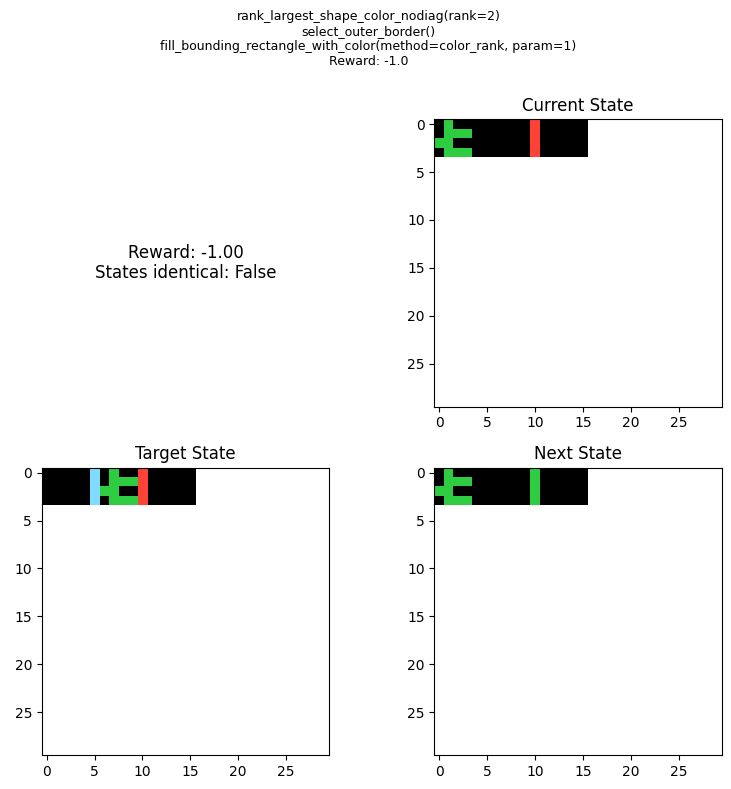

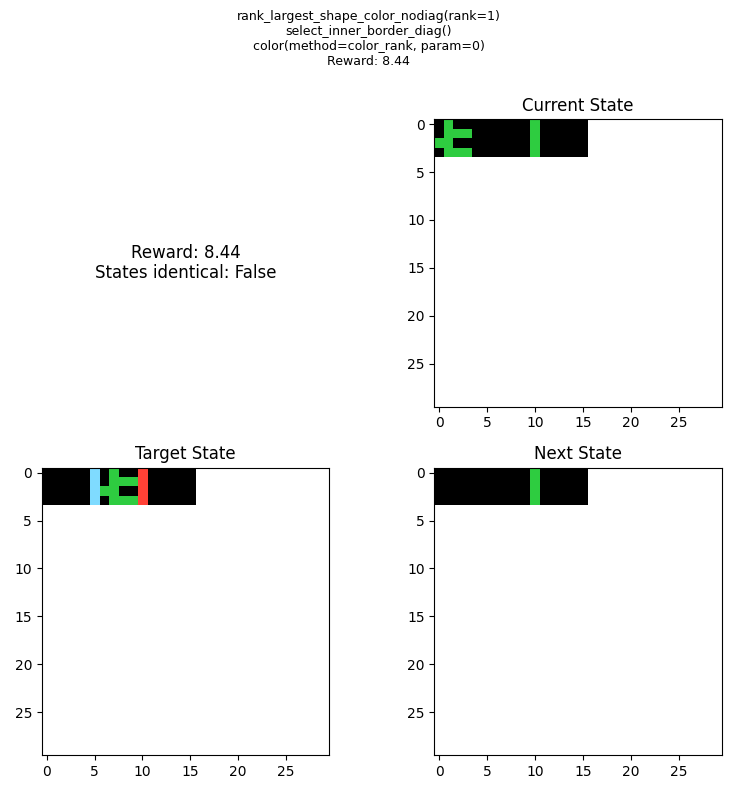

Positive reward: 8.4375


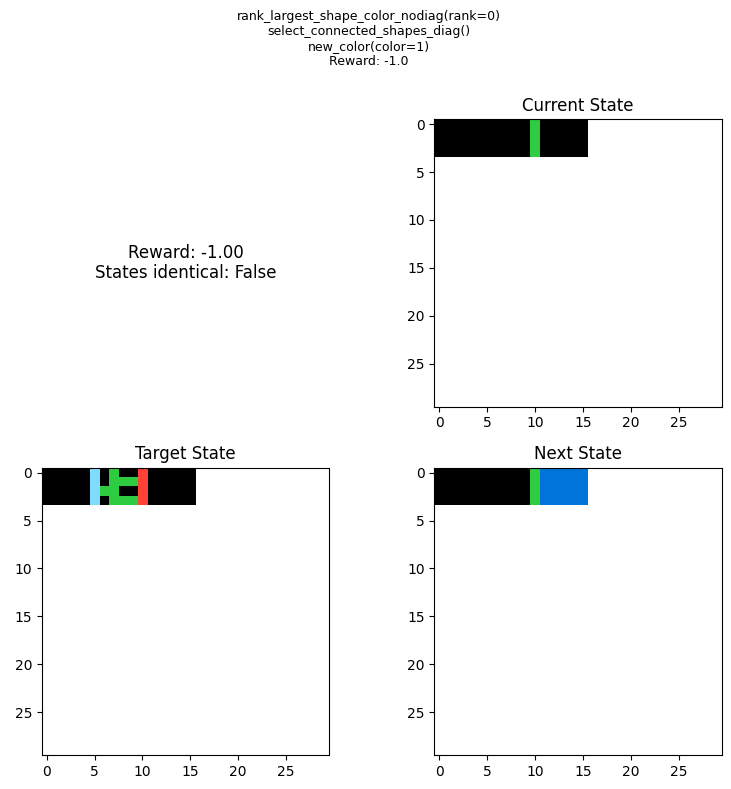

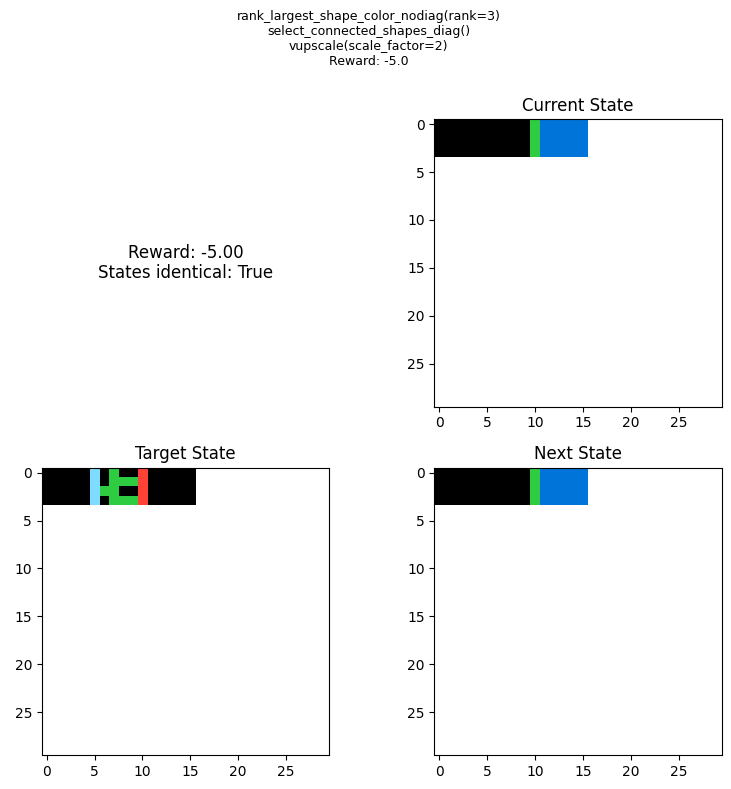

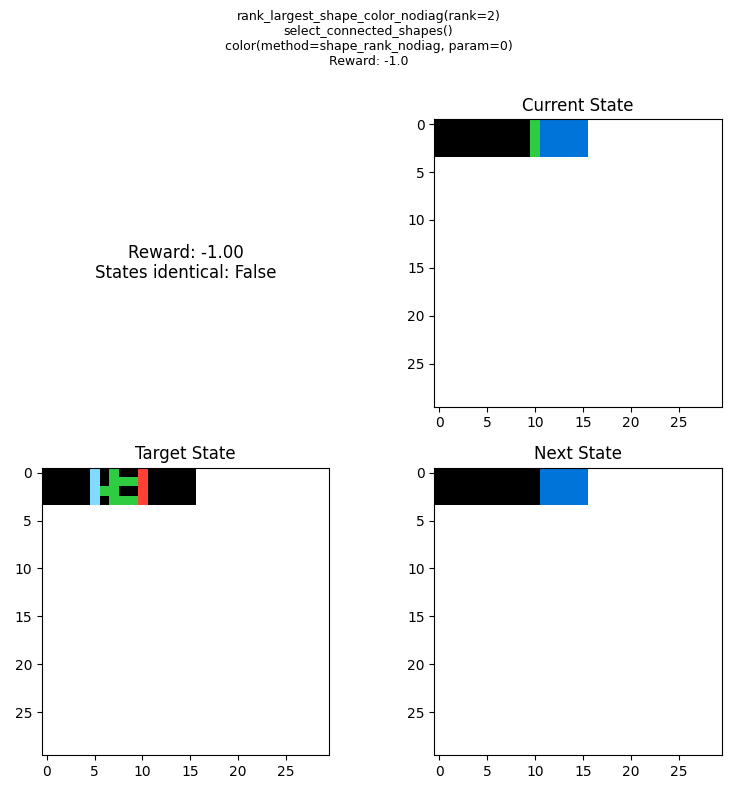

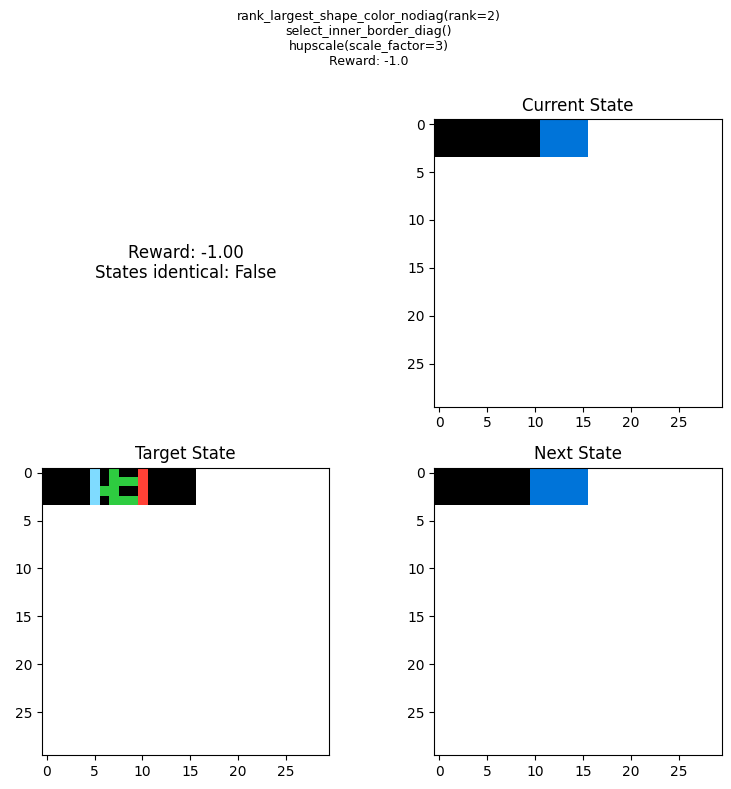

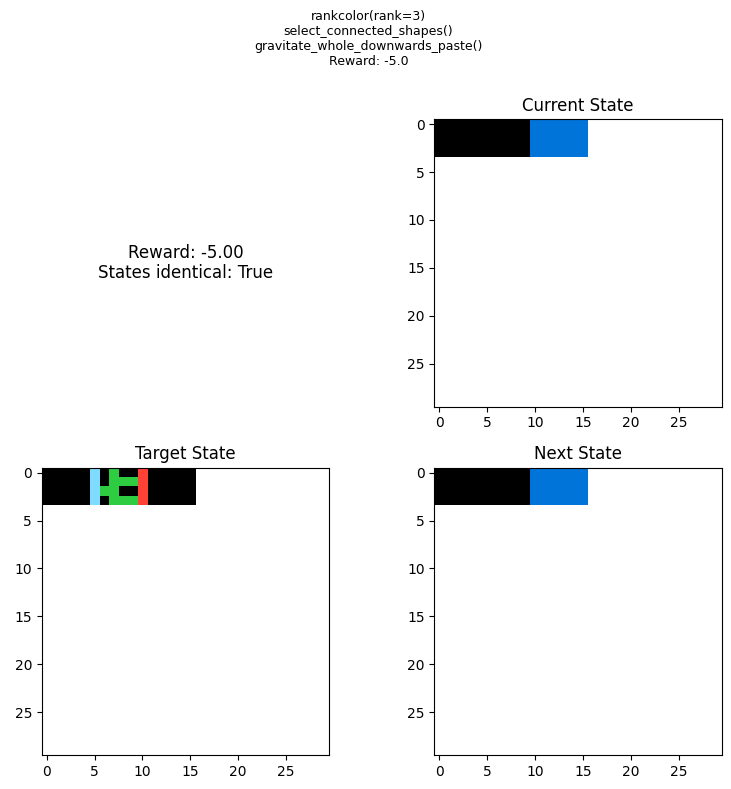

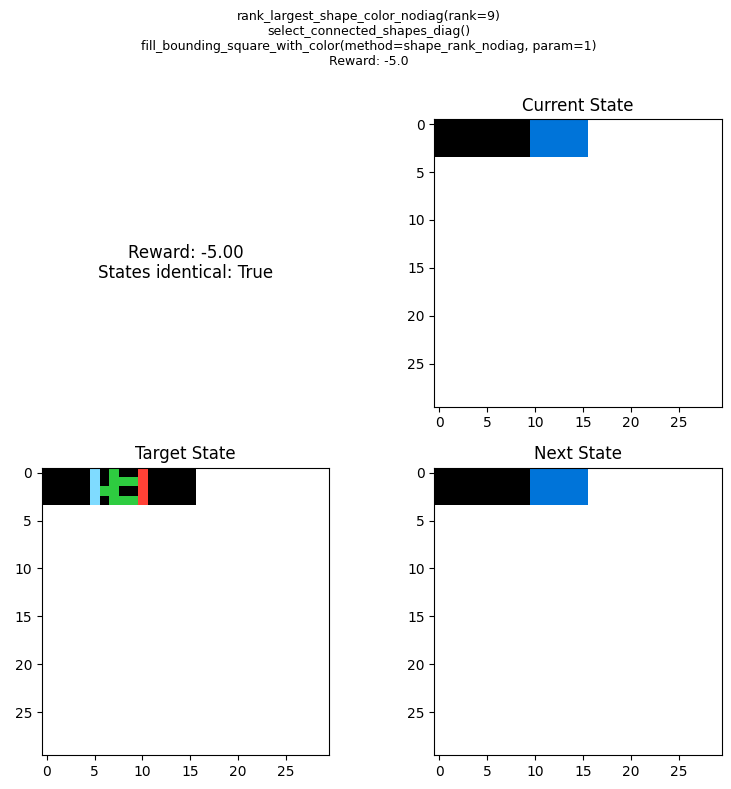

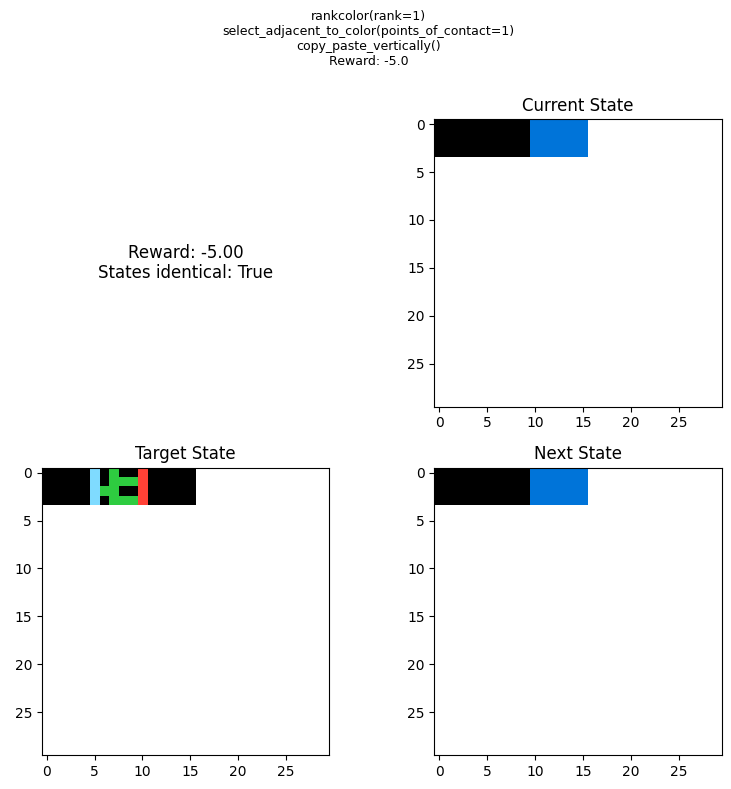

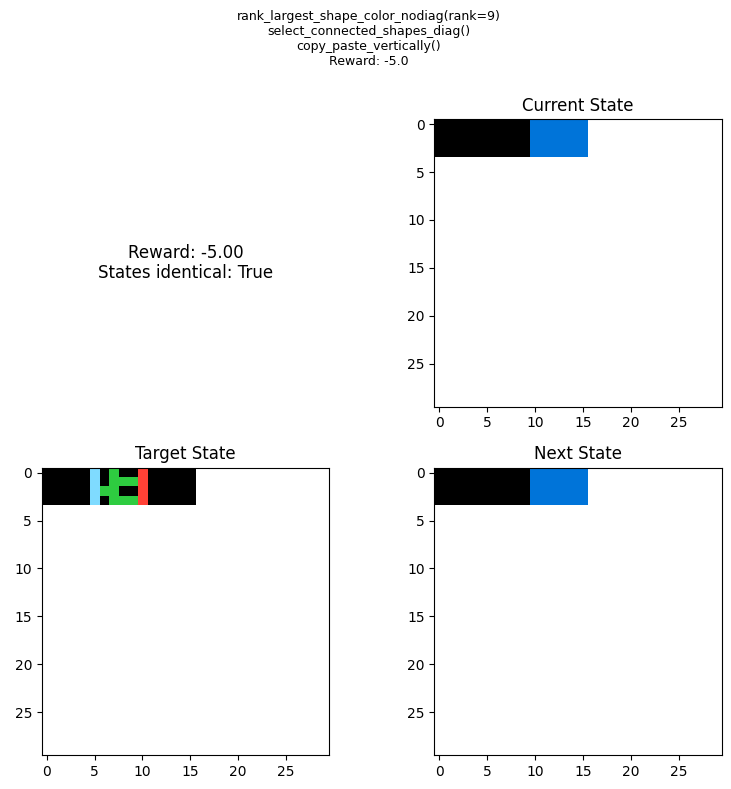

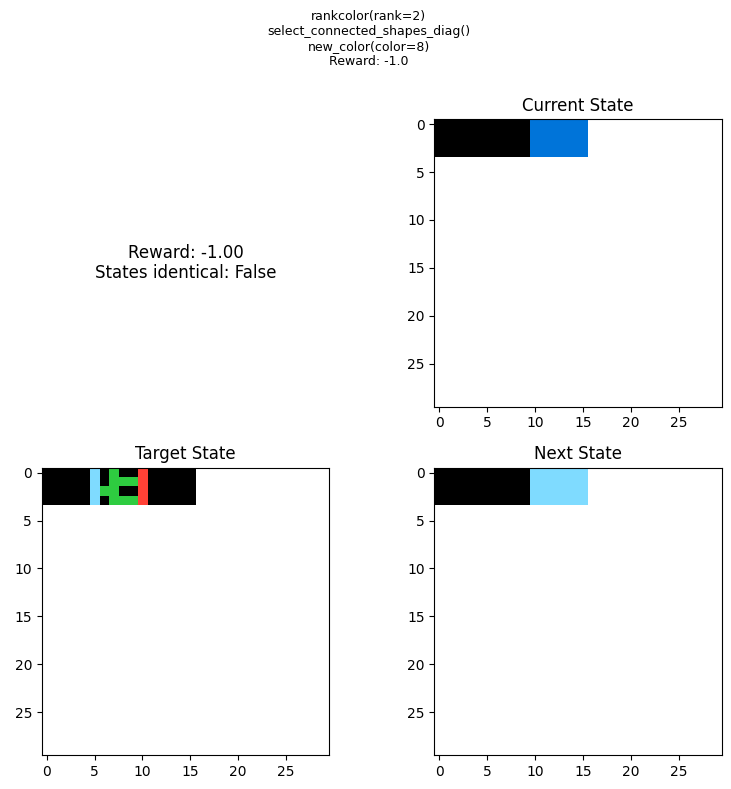

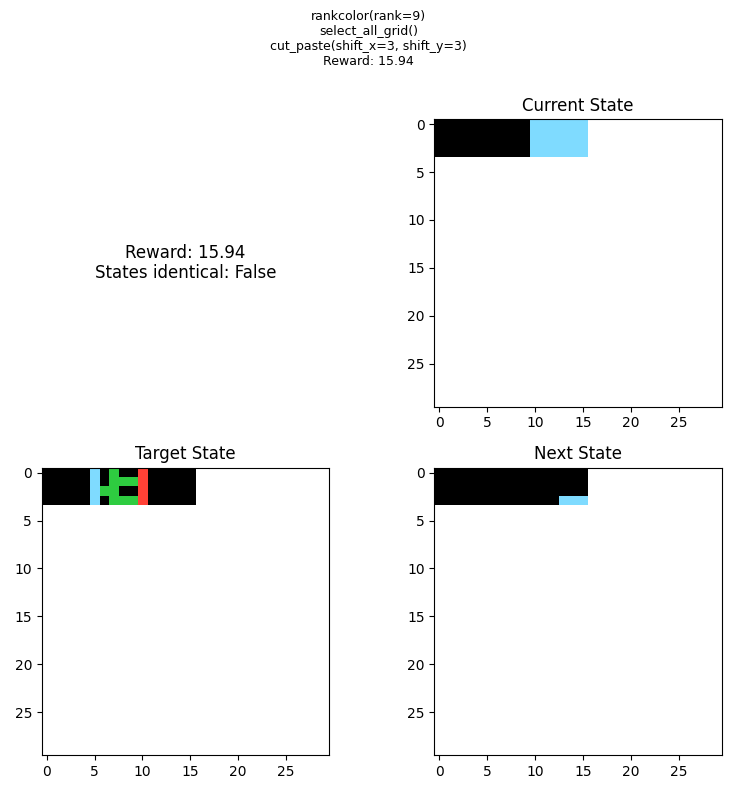

2025-02-19 20:18:19,218 : [Train] Ep:0    | R:  -5.62 | Steps:   12 | EqualStates:    5 | PosR:    2 | eps: 1.000


Positive reward: 15.9375


train/episode,▁
train/episode_reward,▁
train/episode_steps,▁
train/epsilon,▁
train/positive_rewards,▁
train/episode,0
train/episode_reward,-5.62
train/episode_steps,12
train/epsilon,1
train/positive_rewards,2


In [4]:
from utils.util import get_output_folder, setup_logger
from utils.util import set_device
from wolp_agent import WolpertingerAgent
import os

# Change the current working directory to the parent folder
os.chdir('..')

# 2. Set CUDA visible devices
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_ids)[1:-1]
device = set_device()
print(f'Using device: {device}')

# 3. Optionally set a process title
ptitle('WOLP_DDPG')

# 4. Prepare output folder
args.save_model_dir = get_output_folder('../output', args.env)

# 5. Initialize wandb (only if training)
if args.mode == 'train' and wandb.run is None:
    wandb.init(project="arc-v1", config=vars(args), mode="online")

action_space = ARCActionSpace(args)
action_space = ARCActionSpace(args)
print('Sample actions: ', print(action_space))

# 6. Create training and evaluation environments
train_env = ARC_Env(
    path_to_challenges='data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json',
    action_space=action_space
)
eval_env = ARC_Env(
    path_to_challenges='data/RAW_DATA_DIR/arc-prize-2024/arc-agi_evaluation_challenges.json',
    action_space=action_space
)

# 7. Set seeds
if args.seed > 0:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    train_env.seed(args.seed)
    eval_env.seed(args.seed)

# 8. Define state and action dimensions
nb_states = 1805
nb_actions = 20
continuous = False

# 9. Create the agent
agent_args = {
    'nb_states': nb_states,
    'nb_actions': nb_actions,
    'args': args,
    'k': args.k_neighbors,
    'action_space': action_space
}
agent = WolpertingerAgent(**agent_args)

# 10. Optionally load model weights
if args.load:
    agent.load_weights(args.load_model_dir)

# 11. Move agent to GPU if requested
if args.gpu_ids[0] >= 0 and args.gpu_nums > 0 and torch.cuda.is_available():
    agent.cuda_convert()

# 12. Set up logger
if args.mode == 'train':
    setup_logger('RS_log', f'{args.save_model_dir}/RS_train_log')
elif args.mode == 'test':
    setup_logger('RS_log', f'{args.save_model_dir}/RS_test_log')
else:
    raise RuntimeError(f'Undefined mode {args.mode}')
logger = logging.getLogger('RS_log')

# 13. Log hyperparameters
d_args = vars(args)
d_args['nb_states'] = nb_states
d_args['nb_actions'] = nb_actions
d_args['continuous'] = continuous
for k, v in d_args.items():
    logger.info(f"{k}: {v}")

# 14. Run training or (separate) test
if args.mode == 'train':
    logger.info('Starting Training...')
    train(
        continuous=continuous,
        train_env=train_env,
        eval_env=eval_env,
        agent=agent,
        max_episode=args.max_episode,
        max_actions=args.max_actions,
        warmup=args.warmup,
        save_model_dir=args.save_model_dir,
        max_episode_length=args.max_episode_length,
        logger=logger,
        save_per_epochs=args.save_per_epochs,
        eval_interval=args.eval_interval,     # e.g. evaluate every 10 episodes
        eval_episodes=args.eval_episodes     # e.g. 5 episodes each evaluation
    )
    # finish wandb run
    wandb.finish()

elif args.mode == 'test':
    logger.info('Starting Testing...')
    # You could reuse the 'evaluate' or a separate 'test(...)' function
    from train_test import evaluate
    evaluate(
        agent=agent,
        eval_env=eval_env,
        episodes=args.test_episode,
        max_episode_length=args.max_episode_length,
        logger=logger
    )
else:
    raise RuntimeError(f'Undefined mode {args.mode}')